# Metacritic Score Datasets (Feb 2023)

## Load Packages and Functions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import psutil
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, mean_squared_error
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import nltk
import stopwords
from bertopic import BERTopic
from word2number import w2n

In [2]:
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN
import sentence_transformers

In [3]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

## Load Data and Check Content/Size

In [5]:
df_movies = pd.read_csv('/home/jupyter-shantelle/metacritic/movies.csv')
df_games = pd.read_csv('/home/jupyter-shantelle/metacritic/games.csv')
df_tv = pd.read_csv('/home/jupyter-shantelle/metacritic/tv.csv')
# df_music = pd.read_csv('/home/jupyter-shantelle/music.csv')

In [6]:
df_movies.head()

,id,metascore,rating,release_date,sort_no,summary,title,user_score
0,549123,94,TV-14,"July 26, 1989",101,A young boy and his little sister struggle to ...,Grave of the Fireflies (1988),8.9
1,522228,94,PG-13,"December 8, 2000",102,"In 19th century China, a magical sword given b...","Crouching Tiger, Hidden Dragon",8.2
2,550614,94,G,"September 11, 1970",103,"In a French forest in 1798, a child is found w...",The Wild Child,6.5
3,549303,94,TV-PG,"January 15, 1943",104,A young woman discovers her visiting uncle may...,Shadow of a Doubt,8.2
4,539956,94,PG,"June 19, 2015",105,"Growing up can be a bumpy road, and it’s no ex...",Inside Out,8.7


In [7]:
df_games.head()

,id,metascore,platform,release_date,sort_no,summary,title,user_score
0,543718,91,PC,"August 18, 2020",301,"From light planes to wide-body jets, fly highl...",Microsoft Flight Simulator,7.1
1,555108,91,PC,"December 8, 2022",302,"Take up your sword, channel your magic or boar...",Chained Echoes,8.7
2,106820,91,PlayStation 2,"November 7, 2005",303,"Strap on your Guitar Hero SG controller, plug-...",Guitar Hero,8.5
3,110775,91,PC,"November 13, 2008",304,"Players last visited Northrend in ""Warcraft II...",World of Warcraft: Wrath of the Lich King,7.7
4,142864,91,Wii,"October 26, 2010",305,Rock Band returns with the third iteration of ...,Rock Band 3,6.8


In [8]:
df_tv.head()

,id,metascore,release_date,sort_no,summary,title,user_score
0,72329,99,"October 26, 2016",1,Daniel tries to start a new life outside of Pa...,Rectify: Season 4,8.2
1,738,99,"July 19, 1995",2,Comic Garry Shandling draws upon his own talk ...,The Larry Sanders Show: Season 4,4.8
2,51124,99,"September 19, 1995",3,One of several crime and law dramas created by...,Murder One: Season 1,4.6
3,740,99,"March 15, 1998",4,Comic Garry Shandling draws upon his own talk ...,The Larry Sanders Show: Season 6,4.1
4,46560,99,"July 15, 2012",5,The final season for the award-winning drama b...,Breaking Bad: Season 5,9.7


In [9]:
print(df_movies.shape, df_games.shape, df_tv.shape)

(15325, 8) (20022, 8) (3298, 7)


In [10]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15325 entries, 0 to 15324
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            15325 non-null  int64 
 1   metascore     15325 non-null  int64 
 2   rating        14201 non-null  object
 3   release_date  15325 non-null  object
 4   sort_no       15325 non-null  int64 
 5   summary       15322 non-null  object
 6   title         15325 non-null  object
 7   user_score    15325 non-null  object
dtypes: int64(3), object(5)
memory usage: 957.9+ KB


In [11]:
df_movies.drop('id',axis=1,inplace=True)

In [12]:
df_movies['user_score'] = df_movies['user_score'].replace('tbd',np.nan).astype('float')

In [13]:
df_movies.describe()

,metascore,sort_no,user_score
count,15325.000000,15325.000000,12116.000000
mean,59.180555,7663.000000,6.624208
std,17.076007,4424.090773,1.364717
min,1.000000,1.000000,0.300000
25%,48.000000,3832.000000,5.900000
50%,61.000000,7663.000000,6.800000
75%,72.000000,11494.000000,7.600000
max,100.000000,15325.000000,9.200000


<AxesSubplot:>

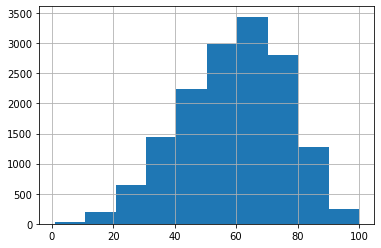

In [14]:
df_movies['metascore'].hist()

<AxesSubplot:>

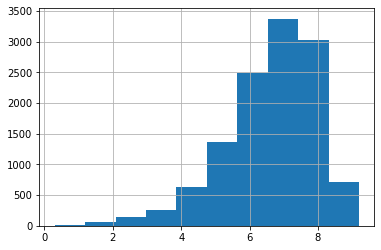

In [15]:
df_movies['user_score'].hist()

In [16]:
df_movies['rating'].unique()

array(['TV-14', 'PG-13', 'G', 'TV-PG', 'PG', 'R', 'Passed', 'Not Rated',
       'TV-G', 'TV-MA', 'Approved', nan, 'Unrated', 'GP', 'M', 'M/PG',
       'NR', 'NC-17', 'Open', 'X', 'MA-17', 'PG--13', 'PG-13`', 'TV-Y7',
       'TV-Y7-FV'], dtype=object)

In [17]:
df_movies['rating'] = df_movies['rating'].replace(['PG--13','PG-13`'],'PG-13').replace(['NR','Unrated'],'Not Rated')
df_movies['rating'] = df_movies['rating'].replace('X','NC-17') #'X' is an outdated rating replaced with 'NC-17'
df_movies['rating'].unique()

array(['TV-14', 'PG-13', 'G', 'TV-PG', 'PG', 'R', 'Passed', 'Not Rated',
       'TV-G', 'TV-MA', 'Approved', nan, 'GP', 'M', 'M/PG', 'NC-17',
       'Open', 'MA-17', 'TV-Y7', 'TV-Y7-FV'], dtype=object)

In [18]:
df_movies['release_date'] = df_movies['release_date'].replace(['TBA','TBD 2022 or 2023'],np.nan)
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'])

In [19]:
df_movies['release_year'] = df_movies['release_date'].dt.year
df_movies['release_month'] = df_movies['release_date'].dt.month
df_movies['release_quarter'] = df_movies['release_date'].dt.quarter
df_movies['release_yearweek'] = df_movies['release_date'].dt.weekofyear

In [20]:
df_movies[df_movies['rating']=='Passed']['release_date'].max()

Timestamp('1976-06-16 00:00:00')

In [21]:
df_movies[df_movies['title'].duplicated()].sort_values('title').head(50)

,metascore,rating,release_date,sort_no,summary,title,user_score,release_year,release_month,release_quarter,release_yearweek
11186,49,G,1996-11-27,11187,"Unleashing every ounce of Disney magic, 101 Da...",101 Dalmatians,6.1,1996.0,11.0,4.0,48.0
10849,50,NaN,2003-05-09,10850,Writer/director Helen Lesnick stars as a newly...,A Family Affair,5.3,2003.0,5.0,2.0,19.0
10147,53,PG-13,2004-05-07,10148,"When their mother dies, two brothers (Arquette...",A Foreign Affair,6.0,2004.0,5.0,2.0,19.0
7499,61,PG-13,1999-05-14,7500,Shakespeare's classic romantic comedy set in 1...,A Midsummer Night's Dream,6.5,1999.0,5.0,2.0,19.0
13882,35,R,2010-04-30,13883,"Nancy, Kris, Quentin, Jesse and Dean all live ...",A Nightmare on Elm Street,4.9,2010.0,4.0,2.0,17.0
8252,59,R,1976-12-17,8253,A has-been rock star falls in love with a youn...,A Star Is Born,4.5,1976.0,12.0,4.0,51.0
813,88,R,2018-10-05,397,"In this new take on the tragic love story, sea...",A Star Is Born,8.4,2018.0,10.0,4.0,40.0
9092,56,PG-13,2009-07-29,9093,"Romance can be risky, perplexing and filled wi...",Adam,8.0,2009.0,7.0,3.0,31.0
14876,25,R,2014-08-08,14877,In the winter of 2002 in chilly upstate New Yo...,After,NaN,2014.0,8.0,3.0,32.0
5830,66,Not Rated,2017-08-09,5831,Boris (Cédric Kahn) and Marie (Bérénice Bejo) ...,After Love,NaN,2017.0,8.0,3.0,32.0


In [22]:
df_movies.isna().sum()

metascore              0
rating              1124
release_date         109
sort_no                0
summary                3
title                  0
user_score          3209
release_year         109
release_month        109
release_quarter      109
release_yearweek     109
dtype: int64

In [23]:
df_movies[df_movies['summary'].isna()]

,metascore,rating,release_date,sort_no,summary,title,user_score,release_year,release_month,release_quarter,release_yearweek
8262,59,Not Rated,NaT,8263,NaN,The Nothing Factory,NaN,NaN,NaN,NaN,NaN
9021,56,R,2018-11-09,9022,NaN,Weightless,NaN,2018.0,11.0,4.0,45.0
12235,44,PG-13,1986-04-25,12236,NaN,Three Men and a Cradle,NaN,1986.0,4.0,2.0,17.0


In [24]:
df_movies.fillna(-1,inplace=True)

<AxesSubplot:>

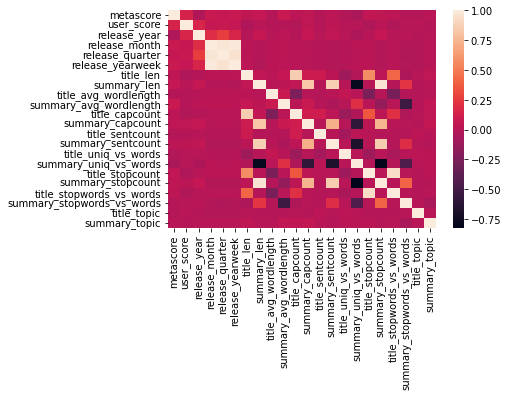

In [57]:
# calculate the correlation matrix
corr = df_movies.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [26]:
df_movies['title_len'] = [len(i) for i in df_movies['title']]
df_movies['summary_len'] = [len(i) for i in df_movies['summary'].astype('str')]

df_movies['title_wordlen'] = [len(i.split()) for i in df_movies['title']]
df_movies['summary_wordlen'] = [len(i.split()) for i in df_movies['summary'].astype('str')]

df_movies['title_avg_wordlength'] = df_movies['title_len']/df_movies['title_wordlen']
df_movies['summary_avg_wordlength'] = df_movies['summary_len']/df_movies['summary_wordlen']

In [27]:
def count_capital_words(text):
    """Count the number of capital letters"""
    return sum(1 for i in text if i.isupper())

df_movies['title_capcount'] = [count_capital_words(i) for i in df_movies['title']]
df_movies['summary_capcount'] = [count_capital_words(i) for i in df_movies['summary'].astype('str')]

In [28]:
def count_punctuations(text):
    """Count the number of each punctuation character"""
    punctuations="!#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
    d=dict()
    for i in punctuations:
        d[str(i)+' count']=text.count(i)
    return d 

df_movies['title_punccount'] = [count_punctuations(i) for i in df_movies['title']]
df_movies['summary_punccount'] = [count_punctuations(i) for i in df_movies['summary'].astype('str')]

In [29]:
def count_sent(text):
    """Count the number of sentences"""
    return len(nltk.sent_tokenize(text))

df_movies['title_sentcount'] = [count_sent(i) for i in df_movies['title']]
df_movies['summary_sentcount'] = [count_sent(i) for i in df_movies['summary'].astype('str')]

In [30]:
def count_unique_words(text):
    """Count the number of unique words"""
    return len(set(text.split()))

df_movies['title_uniq'] = [count_unique_words(i) for i in df_movies['title']]
df_movies['summary_uniq'] = [count_unique_words(i) for i in df_movies['summary'].astype('str')]

In [31]:
df_movies['title_uniq_vs_words'] = df_movies['title_uniq']/df_movies['title_wordlen']
df_movies['summary_uniq_vs_words'] = df_movies['summary_uniq']/df_movies['summary_wordlen']

In [32]:
def count_stopwords(text):
    """Count the number of stopwords"""
    stop_words = list(set(nltk.corpus.stopwords.words('english')))+["film","el","le"]
    word_tokens = nltk.tokenize.word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

df_movies['title_stopcount'] = [count_stopwords(i) for i in df_movies['title']]
df_movies['summary_stopcount'] = [count_stopwords(i) for i in df_movies['summary'].astype('str')]

In [33]:
df_movies['title_stopwords_vs_words'] = df_movies['title_stopcount']/df_movies['title_wordlen']
df_movies['summary_stopwords_vs_words'] = df_movies['summary_stopcount']/df_movies['summary_wordlen']

In [34]:
def remove_stopwords(text):
    """Remove stopwords"""
    text = text.lower()
    stop_words = list(set(nltk.corpus.stopwords.words('english')))+["film","el","le"]
    punctuations="!#$%&''()*+,-./:;<=>?@[\]^_`{|}~’"
    punc_table = str.maketrans(dict.fromkeys(punctuations, ''))
    output= text.translate(punc_table)
    output= [i for i in nltk.tokenize.word_tokenize(output) if i not in stop_words]
    return output

df_movies['title_nostopwords'] = [remove_stopwords(i) for i in df_movies['title']]
df_movies['summary_nostopwords'] = [remove_stopwords(i) for i in df_movies['summary'].astype('str')]

In [35]:
#defining the function for lemmatization
def lemmatizer(text):
    """Lemmatise the text"""
    #defining the object for Lemmatization
    wordnet_lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

df_movies['title_nostopwords_lemm'] = [lemmatizer(i) for i in df_movies['title_nostopwords']]
df_movies['summary_nostopwords_lemm'] = [lemmatizer(i) for i in df_movies['summary_nostopwords']]

In [36]:
df_movies['title_clean'] = [' '.join(i) for i in df_movies['title_nostopwords_lemm']]
df_movies['summary_clean'] = [' '.join(i) for i in df_movies['summary_nostopwords_lemm']]

In [37]:
def remove_numwords(df,lemm_col,clean_col,new_col):
    """Replace number words with numbers"""
    df[new_col] = df[clean_col]
    for i, j in enumerate(df[lemm_col]):
        word_to_num_list = []
        for word in j:
            try:
                word_to_num_list += [str(w2n.word_to_num(word))]
            except ValueError:
                word_to_num_list += [word] 
        df[new_col][i] = ' '.join(word_to_num_list)
    return df
        
df_movies = remove_numwords(df_movies,'title_nostopwords_lemm','title_clean','title_clean_num')
df_movies = remove_numwords(df_movies,'summary_nostopwords_lemm','summary_clean','summary_clean_num')

In [38]:
df_movies.drop(['title_nostopwords','summary_nostopwords','title_nostopwords_lemm','summary_nostopwords_lemm'],
              axis=1,inplace=True)

In [39]:
df_movies

,metascore,rating,release_date,sort_no,summary,title,user_score,release_year,release_month,release_quarter,...,title_uniq_vs_words,summary_uniq_vs_words,title_stopcount,summary_stopcount,title_stopwords_vs_words,summary_stopwords_vs_words,title_clean,summary_clean,title_clean_num,summary_clean_num
0,94,TV-14,1989-07-26 00:00:00,101,A young boy and his little sister struggle to ...,Grave of the Fireflies (1988),8.9,1989.0,7.0,3.0,...,1.0,1.000000,2,5,0.4,0.312500,grave firefly 1988,young boy little sister struggle survive japan...,grave firefly 1988,young boy little sister struggle survive japan...
1,94,PG-13,2000-12-08 00:00:00,102,"In 19th century China, a magical sword given b...","Crouching Tiger, Hidden Dragon",8.2,2000.0,12.0,4.0,...,1.0,0.814815,0,22,0.0,0.407407,crouching tiger hidden dragon,19th century china magical sword given warrior...,crouching tiger hidden dragon,19th century china magical sword given warrior...
2,94,G,1970-09-11 00:00:00,103,"In a French forest in 1798, a child is found w...",The Wild Child,6.5,1970.0,9.0,3.0,...,1.0,0.900000,0,13,0.0,0.433333,wild child,french forest 1798 child found walk speak read...,wild child,french forest 1798 child found walk speak read...
3,94,TV-PG,1943-01-15 00:00:00,104,A young woman discovers her visiting uncle may...,Shadow of a Doubt,8.2,1943.0,1.0,1.0,...,1.0,1.000000,2,7,0.5,0.437500,shadow doubt,young woman discovers visiting uncle may man s...,shadow doubt,young woman discovers visiting uncle may man s...
4,94,PG,2015-06-19 00:00:00,105,"Growing up can be a bumpy road, and it’s no ex...",Inside Out,8.7,2015.0,6.0,2.0,...,1.0,0.778689,0,47,0.0,0.385246,inside,growing bumpy road exception riley uprooted mi...,inside,growing bumpy road exception riley uprooted mi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15320,1,PG,1987-08-22 00:00:00,15321,Dodger must confront the struggles of life as ...,The Garbage Pail Kids Movie,0.7,1987.0,8.0,3.0,...,1.0,0.909091,0,10,0.0,0.454545,garbage pail kid movie,dodger must confront struggle life visited gar...,garbage pail kid movie,dodger must confront struggle life visited gar...
15321,1,Not Rated,2015-06-05 00:00:00,15322,"Three men—Jules Rimet (Gérard Depardieu), Joao...",United Passions,0.7,2015.0,6.0,2.0,...,1.0,0.896552,0,7,0.0,0.241379,united passion,three men—jules rimet gérard depardieu joao ha...,united passion,3 men—jules rimet gérard depardieu joao havela...
15322,1,PG-13,1996-01-12 00:00:00,15323,Five brave scientists are forced to face life ...,Bio-Dome,7.5,1996.0,1.0,1.0,...,1.0,0.923077,0,8,0.0,0.307692,biodome,five brave scientist forced face life form per...,biodome,5 brave scientist forced face life form perple...
15323,1,Not Rated,2005-08-12 00:00:00,15324,Quite definitely one of the most brutal displa...,Chaos,2.5,2005.0,8.0,3.0,...,1.0,0.857143,0,21,0.0,0.375000,chaos,quite definitely one brutal display violence e...,chaos,quite definitely 1 brutal display violence eve...


 ## BERTopic Modelling on Summary

In [48]:
def bertmodel_prep(df,col):
    """Define the bertopic model parameters"""
    umap_model = UMAP(n_neighbors=15, 
                  n_components=5, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=100)
    vectorizer_model = CountVectorizer(min_df=5, #stop_words="english",
                                  max_features=1000)
    hdbscan_model = HDBSCAN(min_cluster_size = 50, min_samples = 100, 
                        metric = 'euclidean', prediction_data = True)
    topic_model = BERTopic(umap_model=umap_model, 
                       vectorizer_model=vectorizer_model, 
                       hdbscan_model=hdbscan_model, #nr_topics="auto",
                       language="english", calculate_probabilities=True,
                      n_gram_range=(1, 3))#, diversity=0.4
    sentence_model = sentence_transformers.SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = sentence_model.encode(df[col], show_progress_bar=False)
    return topic_model, embeddings

def get_topic_preds(df,col,topic_model, embeddings):
    """Fit the bertopic model and return the topics predictions"""
    topics, probabilities = topic_model.fit_transform(df[col], embeddings)
    print(topic_model.get_topic_info())
    tree = topic_model.get_topic_tree(topic_model.hierarchical_topics(df[col]))
    print(tree)
    return topic_model.topics_[:]

In [49]:
topic_model_title, embeddings_title = bertmodel_prep(df_movies, 'title_clean_num')
topic_model_summary, embeddings_summary = bertmodel_prep(df_movies, 'summary_clean_num')

In [50]:
df_movies['title_topic'] = get_topic_preds(df_movies, 'title_clean_num',topic_model_title, embeddings_title)
df_movies['summary_topic'] = get_topic_preds(df_movies, 'summary_clean_num',topic_model_summary, embeddings_summary)

    Topic  Count                               Name
0      -1  10091              -1_love_man_girl_life
1       0   2372                0_miss_mr_love_life
2       1    339              1_night_day_last_good
3       2    296              2_dead_death_die_live
4       3    261     3_everything_thing_nothing_man
5       4    210        4_water_tale_without_beyond
6       5    208            5_sky_light_white_black
7       6    195                    6_12_10_13_year
8       7    173             7_sweet_man_part_whats
9       8    157               8_son_child_kid_like
10      9    140  9_space_beautiful_people_american
11     10    136     10_movie_fantastic_big_captain
12     11    126            11_song_school_live_art
13     12    126           12_road_street_long_hard
14     13    111                13_fat_big_hate_gay
15     14     92        14_crime_hate_future_second
16     15     91              15_men_bad_little_boy
17     16     81           16_age_never_future_dead
18     17   

100%|██████████| 18/18 [00:00<00:00, 172.34it/s]

.
├─miss_mr_song_man_nothing
│    ├─song_school_gay_fat_late
│    │    ├─■──song_school_live_art_gay ── Topic: 11
│    │    └─■──fat_big_hate_gay_plan ── Topic: 13
│    └─miss_mr_man_god_nothing
│         ├─miss_mr_man_nothing_beautiful
│         │    ├─■──everything_thing_nothing_man_im ── Topic: 3
│         │    └─miss_mr_life_love_beautiful
│         │         ├─■──miss_mr_love_life_city ── Topic: 0
│         │         └─■──space_beautiful_people_american_day ── Topic: 9
│         └─■──god_last_ii_captain_nation ── Topic: 17
└─night_movie_day_road_men
     ├─movie_road_men_dead_death
     │    ├─movie_road_men_dead_death
     │    │    ├─dead_death_die_live_dont
     │    │    │    ├─■──another_im_iii_angel_death ── Topic: 18
     │    │    │    └─■──dead_death_die_live_dont ── Topic: 2
     │    │    └─movie_road_men_son_bad
     │    │         ├─men_son_bad_child_kid
     │    │         │    ├─■──men_bad_little_boy_old ── Topic: 15
     │    │         │    └─■──son_child_kid_like_

    Topic  Count                                   Name
0      -1  10303                -1_life_new_story_world
1       0   1842              0_life_mother_family_love
2       1    627          1_detective_police_cop_murder
3       2    509             2_music_band_rock_musician
4       3    412               3_nazi_war_german_jewish
5       4    299             4_earth_alien_planet_space
6       5    289            5_china_japanese_master_art
7       6    212               6_team_player_sport_game
8       7    178             7_art_artist_portrait_work
9       8    173      8_agent_secret_mission_government
10      9    114            9_soldier_war_army_military
11     10    101              10_novel_love_based_story
12     11     98        11_animal_disney_adventure_bear
13     12     92              12_comedy_film_funny_show
14     13     76  13_political_president_american_state


100%|██████████| 13/13 [00:00<00:00, 167.93it/s]

.
├─music_band_art_rock_artist
│    ├─■──comedy_film_funny_show_hilarious ── Topic: 12
│    └─music_band_art_rock_artist
│         ├─team_player_sport_game_school
│         │    ├─■──political_president_american_state_america ── Topic: 13
│         │    └─■──team_player_sport_game_school ── Topic: 6
│         └─music_band_art_artist_rock
│              ├─■──music_band_rock_musician_musical ── Topic: 2
│              └─■──art_artist_portrait_work_photographer ── Topic: 7
└─life_family_new_find_love
     ├─detective_agent_police_murder_cop
     │    ├─■──agent_secret_mission_government_must ── Topic: 8
     │    └─■──detective_police_cop_murder_crime ── Topic: 1
     └─life_family_new_love_mother
          ├─life_family_love_mother_new
          │    ├─life_family_love_mother_new
          │    │    ├─life_family_mother_love_new
          │    │    │    ├─■──novel_love_based_story_woman ── Topic: 10
          │    │    │    └─■──life_mother_family_love_new ── Topic: 0
          │    │   

In [51]:
topic_model_title.visualize_topics(top_n_topics=20)

In [52]:
topic_model_summary.visualize_topics(top_n_topics=20)

In [79]:
topic_model_title.save("my_topic_model_title")

/home/jupyter-shantelle/.local/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [80]:
topic_model_summary.save("my_topic_model_summary")

In [381]:
# Get top 10 terms for a topic
topic_terms = []
for i in range(0,topic_model.get_topic_info().index[-1]):
    topic_terms.append(topic_model.get_topic(i))

In [382]:
list_topics=[]
for i in range(0,17):
    list_topics.append(np.ones(10)*i)
topics_names = pd.DataFrame(list_topics).transpose().melt().value

In [408]:
# Visualize top topic keywords
topic_model.visualize_barchart(top_n_topics=20)

In [409]:
# Visualize term rank decrease
topic_model.visualize_term_rank()

In [412]:
# Visualize similarity using heatmap
topic_model.visualize_heatmap()

In [413]:
# Visualize probability distribution
topic_model.visualize_distribution(topic_model.probabilities_[0], min_probability=0.001) 

In [53]:
# df_movies.to_csv('df_movies_processed.csv')

In [56]:
df_movies.columns

Index(['metascore', 'rating', 'user_score', 'release_year', 'release_month',
       'release_quarter', 'release_yearweek', 'title_len', 'summary_len',
       'title_avg_wordlength', 'summary_avg_wordlength', 'title_capcount',
       'summary_capcount', 'title_sentcount', 'summary_sentcount',
       'title_uniq_vs_words', 'summary_uniq_vs_words', 'title_stopcount',
       'summary_stopcount', 'title_stopwords_vs_words',
       'summary_stopwords_vs_words', 'title_topic', 'summary_topic'],
      dtype='object')

In [55]:
df_movies.drop(['release_date','summary', 'title','title_clean','sort_no',
                'summary_clean', 'title_clean_num', 'summary_clean_num',
                'title_punccount','summary_punccount',
               'title_wordlen', 'summary_wordlen','title_uniq', 'summary_uniq'],axis=1,inplace=True)

In [66]:
df_movies.select_dtypes('object').value_counts()

rating   
R            4938
Not Rated    4025
PG-13        2586
PG           1472
-1           1124
TV-MA         260
G             230
TV-14         149
TV-PG         140
Approved      134
Passed         94
NC-17          83
TV-G           40
GP             23
M               9
M/PG            8
Open            6
TV-Y7           2
MA-17           1
TV-Y7-FV        1
dtype: int64

## Encoding and Train-Test Split

In [69]:
from sklearn.preprocessing import LabelEncoder

def label_encode_columns(dataframe, columns):
    """Label encodes the specified columns of a dataframe"""
    for column in columns:
        le = LabelEncoder()
        dataframe[column] = le.fit_transform(dataframe[column].astype('str'))
        print(le.classes_)
    return dataframe
df_movies_encoded = label_encode_columns(df_movies, df_movies.select_dtypes('object').columns.values)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(df_movies.drop('metascore',axis=1), 
                                                    df_movies['metascore'], 
                                                    test_size=0.30, random_state=42)

In [71]:
y_train.value_counts()

64    261
65    256
68    252
67    251
66    250
     ... 
8       4
99      3
7       3
5       2
6       1
Name: metascore, Length: 97, dtype: int64

## Model

In [75]:
linear_reg = LinearRegression()
decision_tree_reg = DecisionTreeRegressor(random_state = 42)
random_forest_reg = RandomForestRegressor(random_state = 42)
xgboost_reg = XGBRegressor(seed = 42)

# Step 4: Hyperparameter Tuning
linear_reg_params = {}
decision_tree_reg_params = {'max_depth': [3, 5, 7]}
random_forest_reg_params = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]}
xgboost_reg_params = {'learning_rate': [0.1, 0.3, 0.5], 'max_depth': [3, 5, 7]}

linear_reg_grid = GridSearchCV(linear_reg, linear_reg_params, cv=5)
decision_tree_reg_grid = GridSearchCV(decision_tree_reg, decision_tree_reg_params, cv=5)
random_forest_reg_grid = GridSearchCV(random_forest_reg, random_forest_reg_params, cv=5)
xgboost_reg_grid = GridSearchCV(xgboost_reg, xgboost_reg_params, cv=5)

linear_reg_grid.fit(X_train, y_train)
decision_tree_reg_grid.fit(X_train, y_train)
random_forest_reg_grid.fit(X_train, y_train)
xgboost_reg_grid.fit(X_train, y_train)

# Step 5: Model Training
linear_reg_model = linear_reg_grid.best_estimator_
decision_tree_reg_model = decision_tree_reg_grid.best_estimator_
random_forest_reg_model = random_forest_reg_grid.best_estimator_
xgboost_reg_model = xgboost_reg_grid.best_estimator_

In [76]:
linear_reg_model.fit(X_train, y_train)
decision_tree_reg_model.fit(X_train, y_train)
random_forest_reg_model.fit(X_train, y_train)
xgboost_reg_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [81]:
y_pred_linear = linear_reg_model.predict(X_test)
y_pred_dt = decision_tree_reg_model.predict(X_test)
y_pred_rf = random_forest_reg_model.predict(X_test)
y_pred_xgb = xgboost_reg_model.predict(X_test)

In [82]:
# Step 5: Evaluate the model performance
print("LinearReg: r-score = ",metrics.r2_score(y_test, y_pred_linear), ", MSE = ", 
      metrics.mean_squared_error(y_test, y_pred_linear),", MAPE = ",
      metrics.mean_absolute_percentage_error(y_test, y_pred_linear))

print("Decision Tree: r-score = ",metrics.r2_score(y_test, y_pred_dt), ", MSE = ", 
      metrics.mean_squared_error(y_test, y_pred_dt),", MAPE = ",
      metrics.mean_absolute_percentage_error(y_test, y_pred_dt))

print("Random Forest: r-score = ",metrics.r2_score(y_test, y_pred_rf), ", MSE = ", 
      metrics.mean_squared_error(y_test, y_pred_rf),", MAPE = ",
      metrics.mean_absolute_percentage_error(y_test, y_pred_rf))

print("XGBoost: r-score = ",metrics.r2_score(y_test, y_pred_xgb), ", MSE = ", 
      metrics.mean_squared_error(y_test, y_pred_xgb),", MAPE = ",
      metrics.mean_absolute_percentage_error(y_test, y_pred_xgb))

LinearReg: r-score =  0.06906265014799318 , MSE =  270.2670437282094 , MAPE =  0.3174741959022944
Decision Tree: r-score =  0.2943551034715307 , MSE =  204.8607891142896 , MAPE =  0.2632827766998192
Random Forest: r-score =  0.33745079689923907 , MSE =  192.3493718186192 , MAPE =  0.2533494851491093
XGBoost: r-score =  0.35155470318214177 , MSE =  188.25476646552448 , MAPE =  0.253455214202358


<AxesSubplot:xlabel='metascore'>

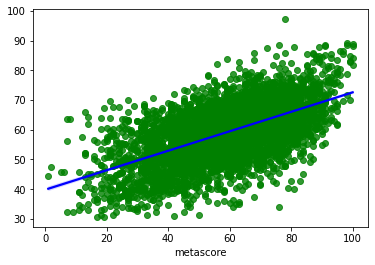

In [83]:
sns.regplot(y_test, y_pred_xgb, scatter_kws={"color": "green"}, line_kws={"color": "blue"}) 

In [84]:
xgboost_reg_model.best_ntree_limit

100

In [86]:
y_pred_xgb = xgboost_reg_model.predict(X_test, ntree_limit=xgboost_reg_model.best_ntree_limit)

In [87]:
print("XGBoost: r-score = ",metrics.r2_score(y_test, y_pred_xgb), ", MSE = ", 
      metrics.mean_squared_error(y_test, y_pred_xgb),", MAPE = ",
      metrics.mean_absolute_percentage_error(y_test, y_pred_xgb))

XGBoost: r-score =  0.35155470318214177 , MSE =  188.25476646552448 , MAPE =  0.253455214202358


In [89]:
# save in JSON format
xgboost_reg_model.save_model("xgboost_reg_model_metascore.pkl")